In [1]:
import warnings; warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np

from astropy.constants import m_p
from spectral_cube import SpectralCube
from astropy.io import fits

from scipy.optimize import fsolve
from astropy.visualization import simple_norm
from photutils import CircularAperture, aperture_photometry
from astropy.constants import k_B, G

In [2]:
eta = 0.5 # telescope efficiency (Introduction of this paper: https://www.sciencedirect.com/science/article/pii/S0275106200000825)

In [3]:
files = {

    "12CO(1-0)": "ngc1333_12co10_fcrao.fits",
    "13CO(1-0)": "ngc1333_13co10_fcrao.fits",
    "C18O(1-0)": "ngc1333_c18o10_fcrao.fits"

}


\newpage

#### **(a) INTEGRATED INTENSITY MAPS**

Equation for the 0th moment (integrated intensity) is given by 

$$
M_0 = \int I_v dv
$$

`0th moment - the integrated intensity over the spectral line. Units are cube unit times spectral axis unit (e.g., K km/s).`

\url{https://spectral-cube.readthedocs.io/en/latest/moments.html}

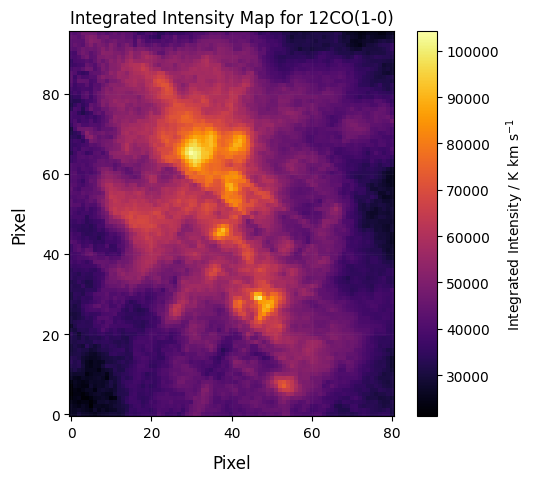

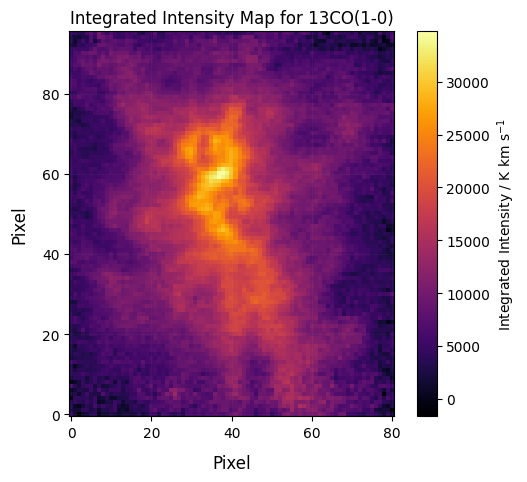

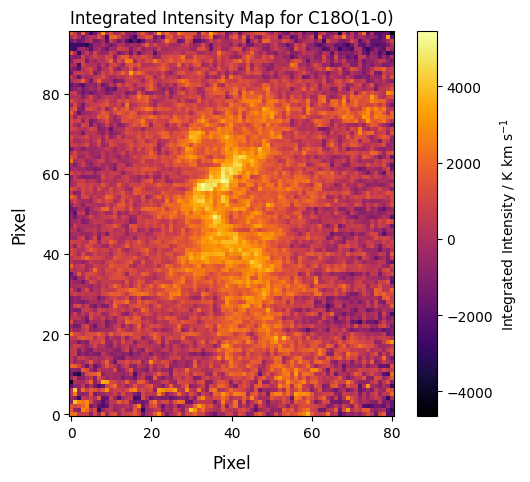

In [4]:
moment0_maps = {}
moment1_maps = {}

for label, file in files.items():

    cube = SpectralCube.read(file) # load the cube
    
    # first of all we need to convert the antenna temperature to brightness temperature using the telescope efficiency
    cube_tb = cube / eta

    # the we calculate the moment 0 map (integrated intensity) using a build-in function of SpectralCube
    moment0 = cube_tb.moment(order = 0)
    moment0_maps[label] = moment0

    # we can also calculate the moment 1 map (velocity field) using the same build-in function of SpectralCube
    moment1 = cube_tb.moment(order = 1)
    moment1_maps[label] = moment1

    # plotting (0-th moment)
    fig, ax = plt.subplots(figsize = (6, 5))
    ax.grid(alpha = 0.05)
    ax.set_xlabel('Pixel', fontsize = 12, labelpad = 10)
    ax.set_ylabel('Pixel', fontsize = 12, labelpad = 10)
    ax.set_title(f'Integrated Intensity Map for {label}', fontsize = 12, loc = 'right')
    im = plt.imshow(moment0.value, origin = 'lower', cmap = 'inferno')
    plt.colorbar(im, label = r'Integrated Intensity / K km s$^{-1}$')

**Discussion:** 

12CO(1-0) is usually the most abundance and optically thick molecule in the ISM; tracing more extended and diffuse molecular gas. We expect a broader and more widespread emission as seen from the integrated intensity map. 13CO(1-0) is less abundant than 12CO(1-0) but it is typically optically thinner; tracing denser gas in comparison to 12CO(1-0). We see from the integrated intensity more localised structures around cores and filaments. C18O(1-0) on the other side is even less abundant and usually optically thin; tracing the densest most shielded regions. Emission is more compact and tends to peaks at core positions. It is usually correlated with outflows in a perpendicular direction.

\newpage

#### **(b) EXCITATION TEMPERATURE MAP USING THE PEAK EMISSION OF THE 12CO(1-2) IN EACH PIXEL**

Let's assume Local Thermodynamic Equilibrium (LTE) and that 12CO(1-2) is optically thick ($\tau\gg1$), so we can derive the excitation temperature ($T_{\rm ex}$) from the observed brightness temperature ($T_{\rm B}$) using the radiative transfer equation (slide 16, class 19; Zhang et al. 2016, ApJ, 832, 158, pp. 9; Pineda et al. 2008, ApJ, 679, 481, eq. (6)):

$$
T_{\rm ex} = \frac{5.5}{\log{\left(1 + \frac{5.5}{T_{\rm B} + 0.82}\right)}}
$$

In [5]:
cube_12co = SpectralCube.read(files["12CO(1-0)"])
cube_12co_tb = cube_12co / eta # brightness temperature converted from the antenna temperature

peak_tb = cube_12co_tb.max(axis = 0) # maximum brightness temperature along the spectral axis for each pixel
tb_vals = np.clip(peak_tb.value, 1e-3, None) # convert to numpy array and avoid log(0) issues

In [6]:
tex_vals = 5.5 / np.log(1 + (5.5 / (tb_vals + 0.82)))
tex_vals[tb_vals < 1.0] = np.nan  # ignore very faint regions, i.e., mask out low TB values that are likely noise


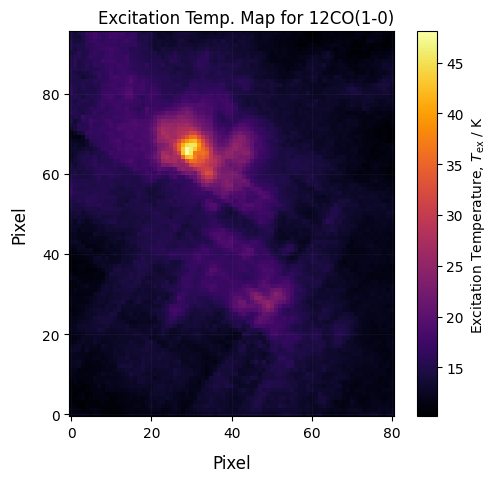

In [7]:
# plotting
fig, ax = plt.subplots(figsize = (6, 5))
ax.grid(alpha = 0.05)   
ax.set_xlabel('Pixel', fontsize = 12, labelpad = 10)
ax.set_ylabel('Pixel', fontsize = 12, labelpad = 10)
ax.set_title(f'Excitation Temp. Map for 12CO(1-0)', fontsize = 12, loc = 'right')
im = plt.imshow(tex_vals, origin = 'lower', cmap = 'inferno')
plt.colorbar(im, label = r'Excitation Temperature, $T_{\rm ex}$ / K')

In [8]:
tex_vals.mean() # average excitation temperature

14.615908

In this map we see excitation temperatures ranging roughly from 15 to 50 K for NGC 1333 which is typical for molecular clouds (Zhang et al. 2016, ApJ, 832, 158; Dunham et al. 2014, 783, 29). Higher $T_{\rm ex}$ regions ($>15-20~K$) likely trace dense star-forming cores with embedded sources responsible for heating the gas, whilst lower $T_{\rm ex}$ ($<12~K$) regions are colder, more quiescent gas. We assumed in this case that the 12CO(1-0) emission is optically thick, is under LTE, and uniform background temperature (CMB = 2.73 K). 

\newpage

#### **(c) MASS OF THE CLOUD**

From *Tools of Radio Astronomy* (Wilson+; Eq. 16.43), ${\rm H}_{2}$ column density and CO column density are related via

$$
    {\rm N}({\rm H}_2) = \left[\frac{{\rm N}(^{18}{\rm CO})}{2.29\times 10^{14}}\right] = \left[\frac{{\rm N}(^{13}{\rm CO})}{2.18\times 10^{14}}\right] \times 10^{21}, 
$$

where we define the "X"-factor as

$$
{\rm X} \equiv \left[\frac{{\rm N}({\rm H}_2)}{{\rm N}({\rm CO})}\right]
$$

However, (from Wilson+), *as noted by the authors of various such studies, a scatter of factor two to five in the correlations is always present*, so the exact ratio is not that one. I'll assume different ones in the following.

Also as noted in Plunkett+2013, *The ratio of [H2/13CO] is an important source of uncertainty in the calculations. Some studies found this ratio to be about 0.5 times the value we use here (e.g. Pineda et al. 2008), so the outflow masses may be less according to this factor, but here we use the value of $7\times10^{5}$ from Frerking et al. (1982) to allow for more straight-forward comparisons with other similar studies.*

In [9]:
# assumptions

distance = 300 * u.pc # distance of the source
pixel_size = 25 * u.arcsec
tex = tex_vals.mean() # excitation temperature (Plunkett et al., 2013, ApJ, 774, 22)

# convert pixel size to cm
pixel_size_rad = pixel_size.to(u.rad)
pixel_size_cm = (pixel_size_rad * distance.to(u.cm)).value
pix_area_cm2 = pixel_size_cm**2

X_12CO = 1e4   # H2 / 12CO (lower, due to abundance); optical depth is often high for 12CO
X_13CO = 3e5  # H2 / 13CO; Lower abundance, more optically thin. The ratio can be affected by isotope-selective photodissociation and chemical fractionation.
X_C18O = 3e6   # H2 / C18O; Even lower abundance than 13CO assumed by one order of magnitude. The ratio can be affected by photodissociation. 

# Similar assumed values also appear in Warin et al. 1996, A&A, 306, 935 (https://ui.adsabs.harvard.edu/abs/1996A%26A...306..935W/abstract)

In [10]:
cube_12 = SpectralCube.read("ngc1333_12co10_fcrao.fits").with_spectral_unit(u.km/u.s)
cube_13 = SpectralCube.read("ngc1333_13co10_fcrao.fits").with_spectral_unit(u.km/u.s)
cube_18 = SpectralCube.read("ngc1333_c18o10_fcrao.fits").with_spectral_unit(u.km/u.s)

In [11]:
# calculate 0th moments
mom0_12 = cube_12.moment0().value
mom0_13 = cube_13.moment0().value
mom0_18 = cube_18.moment0().value

CO isotopologues column density is given in general by 

$$
{\rm N}({\rm CO}) = 3.0\times10^{14} ~ T_{\rm ex} ~ e^{\alpha / T_{\rm ex}} \cdot \int {\rm T}_{\rm B}~d{\rm v}~[\text{cm}^{-2}], \quad \alpha \approx 5.2-5.5
$$

In [12]:
# Column density for optically thin CO(1-0)

def column_density_CO(mom0, tex, line_Eu_K):
    return 3e14 * tex * np.exp(line_Eu_K / tex) * mom0 # should be given in cm^-2

# Note: this is a simplified version of the equation, where we assume the line is optically thin (tau << 1) and so far no correction for opacity is applied (tau / (1-e^-tau) ~ 1 here).
# We are also considering the Rayleigh-Jeans approximation, where the brightness temperature is equal to the excitation temperature (T_b = T_ex).
# The line_Eu_K is the energy of the upper level in Kelvin, which can be calculated from the frequency of the transition using the formula: E_u = h * nu / k_B, where h is Planck's constant and k_B is Boltzmann's constant. I used roughly values I saw in the literature.
# From this RJ approximation J_nu(T) \approx T_b = T_ex, we can get the column density of CO molecules in the upper level of the transition.

In [13]:
line_Eu_K_12CO = 5.53  # K
line_Eu_K_13CO = 5.29  # K
line_Eu_K_C18O = 5.27  # K

N_12CO = column_density_CO(mom0_12, tex, line_Eu_K_12CO) # column density

N_13CO = column_density_CO(mom0_13, tex, line_Eu_K_13CO)
N_C18O = column_density_CO(mom0_18, tex, line_Eu_K_C18O)

# and convert to H2 column density via the X-factor
N_H2_12 = N_12CO * X_12CO
N_H2_13 = N_13CO * X_13CO
N_H2_18 = N_C18O * X_C18O

Then, given the hydrogen column density, we can estimate the mass following (see e.g., Eq 7 in Garden et al. (1991), ApJ, 374, 540)

$$
{\rm M} = \mu~m_{\rm H}~\sum {\rm N}({\rm H}_2) A_{\rm px}, 
$$

where we assume a mean molecular weight of 2.3, $m_{\rm H}$ is the hydrogen atom mass, and $A_{\rm px}$ is the pixel area in cm2

In [14]:
def mass_from_column(N_H2):
    return np.nansum(N_H2) * pix_area_cm2 * 2.3 * m_p.cgs.value

In [15]:
mass_12 = (mass_from_column(N_H2_12) * u.g).to(u.Msun)
mass_13 = (mass_from_column(N_H2_13) * u.g).to(u.Msun)
mass_18 = (mass_from_column(N_H2_18) * u.g).to(u.Msun)

print(f"Mass from 12CO(1-0): {mass_12:.2f}")
print(f"Mass from 13CO(1-0): {mass_13:.2f}")
print(f"Mass from C18O(1-0): {mass_18:.2f}")

# 5200-5300 MSun in total mass from 13CO(1-0) with X = 7e6 is consistent with the results found in Warin et al. 1996, A&A, 306, 935 (https://ui.adsabs.harvard.edu/abs/1996A%26A...306..935W/abstract)

Mass from 12CO(1-0): 287.54 solMass
Mass from 13CO(1-0): 1838.72 solMass
Mass from C18O(1-0): 1452.41 solMass


In [16]:
# The mass of the cloud estimated from 13CO(1-0) and C18(1-0) are roughly similar but an order of magnitude higher than the mass estimated from 12CO(1-0) because the last is optically thick.

\newpage

#### **(d) OPACITY-CORRECTED MASS**

Let's assume that C18O is optically thin, so its peak brightness can be used directly. 

13CO is partially optically thick and needs correction; the excitation temperatures are assumed to be the same for both lines.

Take

$$
R = \frac{[^{13}\text{CO}]}{[\text{C}^{18}\text{O}]} \approx 7.3
$$

We solve for $\tau_{13}$ in 

$$
\frac{T_{13}}{T_{18}} = \frac{1 - e^{-\tau_{13}}}{1 - e^{-\tau_{13}/R}}
$$

and apply an opacity correction (see Eq. 1 in Goldsmith et al. (1984; 1984ApJ...286..599G); see also +/- Eq. 9 in Pineda et al., 2008, ApJ, 679, 481)

$$
{\rm N}(^{13}\text{CO}) = {\rm N}_{\text{optically thin}} \cdot \frac{\tau}{1 - e^{-\tau}}
$$

As noted, *This approximation is accurate to within 15% for $\tau$(13CO) < 2 (Spitzer 1968), and always overestimates the column density for $\tau$(13CO) > 1 (Spitzer 1968)*, so it has limitations. 

In [17]:
R = 7.3 # 13CO / C18O abundance ratio (Ubagai et al 2019 Res. Notes AAS 3 78)

In [18]:
T13_peak = cube_13.max(axis = 0).value
T18_peak = cube_18.max(axis = 0).value

In [19]:
ratio_map = np.where(T18_peak > 0.3, T13_peak / T18_peak, np.nan)

In [20]:
# solve for the optical depth

def solve_tau(r_obs, R_iso = 7.3):
    def equation(tau):
        return (1 - np.exp(-tau)) / (1 - np.exp(-tau / R_iso)) - r_obs
    try:
        return fsolve(equation, x0 = 0.5)[0]
    except:
        return np.nan
    
tau13_map = np.vectorize(solve_tau)(ratio_map) # apply the function to the entire map
moment0_13 = cube_13.moment0().value # 0th moment
N_13CO_thin = 3e14 * tex * np.exp(5.29 / tex) * moment0_13  # cm^-2 
correction_factor = tau13_map / (1 - np.exp(-tau13_map)) # optical depth correction factor

N_13CO_corrected = N_13CO_thin * correction_factor # corrected column density
N_H2_corrected = N_13CO_corrected * X_13CO # corrected H2 column density

In [21]:
# and calculate total mass
mass_g = np.nansum(N_H2_corrected) * pix_area_cm2 * 2.3 * m_p.cgs.value
mass_Msun = (mass_g * u.g).to(u.Msun)

print(f'Opacity-corrected cloud mass from 13CO(1-0): {mass_Msun:.2f}')

Opacity-corrected cloud mass from 13CO(1-0): 3174.53 solMass


In [22]:
# Notice that 
mass_Msun / mass_13
# i.e., the opacity correction factor is about:

<Quantity 1.72648696>

which is barely consistent with opacity-corrected H I column density factors like 1.2 in Pingel et al. (2018) ApJ 856:136. 

\newpage

#### **(e/f) CORES IDENTIFICATION and MASS ESTIMATIVE**

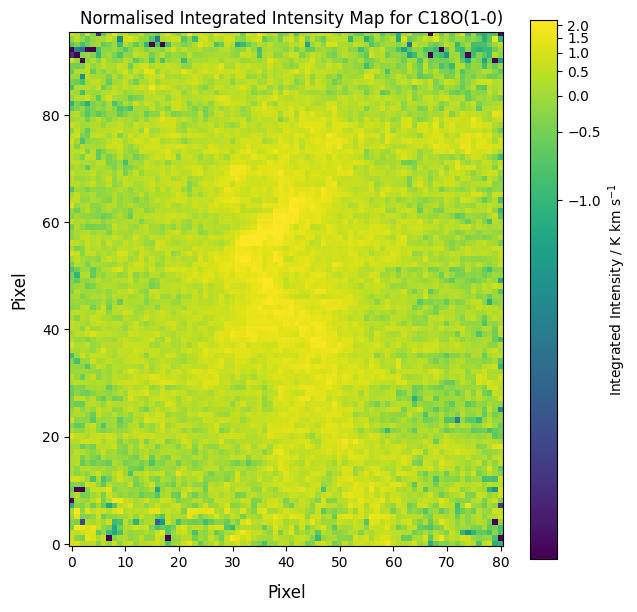

In [23]:
cube_C18O = SpectralCube.read('ngc1333_c18o10_fcrao.fits').with_spectral_unit(u.km/u.s)
c18o_moment0 = cube_C18O.moment0().value

# let us first normalise the data
norm = simple_norm(c18o_moment0, 'log', percent = 99.5)

fig, ax = plt.subplots(figsize = (7, 7))
ax.grid(alpha = 0.05)
ax.set_xlabel('Pixel', fontsize = 12, labelpad = 10)
ax.set_ylabel('Pixel', fontsize = 12, labelpad = 10)
ax.set_title(f'Normalised Integrated Intensity Map for C18O(1-0)', fontsize = 12, loc = 'right')
im = plt.imshow(c18o_moment0, origin = 'lower', cmap = 'viridis', norm = norm)
plt.colorbar(im, label = r'Integrated Intensity / K km s$^{-1}$')

[(30.0, 80.0), (20.0, 60.0)]

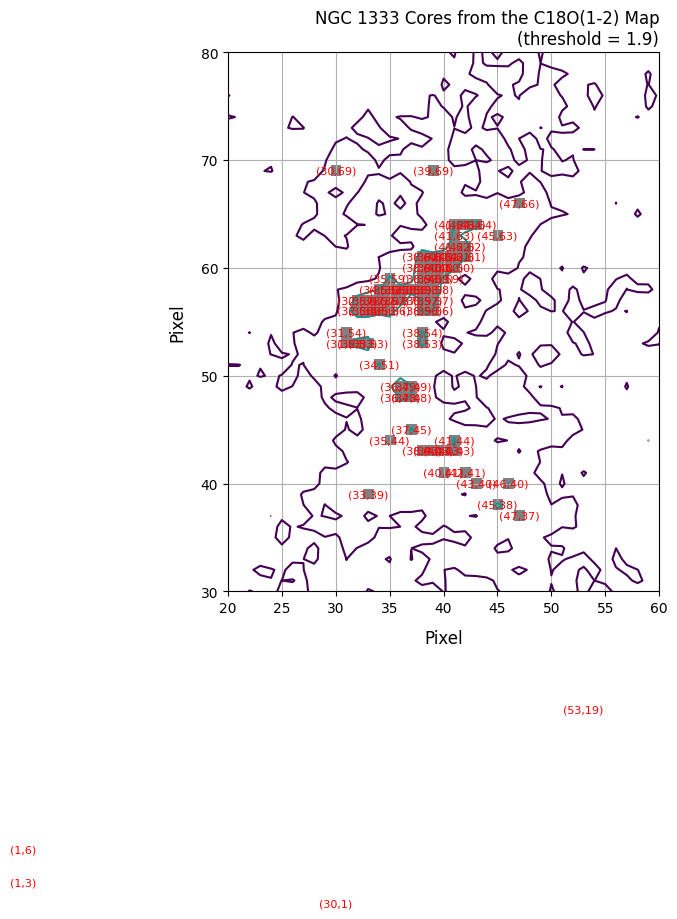

In [24]:
# and set a threshold (1, or 2, ...)
threshold = 1.9 # to not be 2.
core_mask = c18o_moment0 > threshold

# plot - this figure is not so pretty but just to inform the cores positions
fig, ax = plt.subplots(figsize = (8, 7))
ax.grid(alpha = 1)
ax.set_xlabel('Pixel', fontsize = 12, labelpad = 10)
ax.set_ylabel('Pixel', fontsize = 12, labelpad = 10)
plt.contour(c18o_moment0, levels = [1.0, 2.0, 3.0], cmap = plt.cm.viridis, zorder = 100)
ax.imshow(core_mask, cmap = plt.cm.Greys, origin = 'lower', alpha = 0.5, zorder = -100)
ax.set_title(f'NGC 1333 Cores from the C18O(1-2) Map\n(threshold = {threshold})', fontsize = 12, loc = 'right')

y_coords, x_coords = np.where(core_mask)

# Annotate each core position
for (x, y) in zip(x_coords, y_coords):
    ax.text(x, y, f'({x},{y})', fontsize=8, color='red', ha='center', va='center', zorder=200)

ax.set(ylim = (30, 80), xlim = (20, 60))

Text(0.5, 0.92, 'Cores from C$^{18}$O(1-2) Map (Threshold = 1.9)')

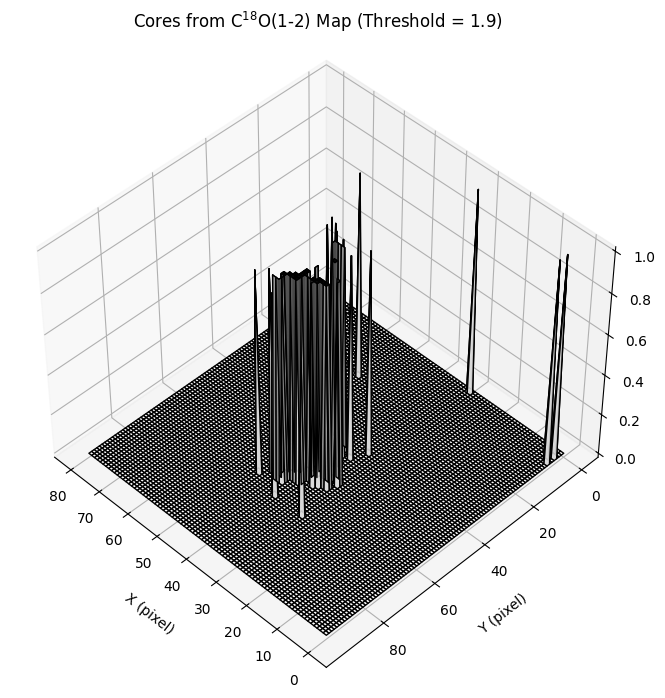

In [25]:
y_coords, x_coords = np.where(core_mask)

# 3D plot
from mpl_toolkits.mplot3d import Axes3D

data = core_mask.astype(float)  # Convert True/False to 1/0
ny, nx = data.shape
x = np.arange(nx)
y = np.arange(ny)
X, Y = np.meshgrid(x, y)

# Create 3D plot
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')

# Plot the surface
ax.plot_surface(X, Y, data, cmap = 'Greys', edgecolor = 'k', alpha = 0.9, rstride = 1, cstride = 1)

# Adjust view angle
ax.view_init(elev = 45, azim = 135)

# Labels and title
ax.set_xlabel('X (pixel)', labelpad = 10)
ax.set_ylabel('Y (pixel)', labelpad = 10)
ax.set_title(f'Cores from C$^{{18}}$O(1-2) Map (Threshold = {threshold})', pad = 20)


In [26]:
y_coords, x_coords = np.where(core_mask)
xy_coords = np.column_stack((x_coords, y_coords))

In [27]:
# perform aperture photometry
position = (40, 60) # xy coordinates of the center of the core (roughly)
r_aperture_pix = 1 # (2) pixels to just focus on the core
aperture = CircularAperture(position, r_aperture_pix)

# physical area
pix_size_cm = (pixel_size.to(u.rad) * distance.to(u.cm)).value
area_pix_cm2 = pix_size_cm**2
n_pix = np.pi * (r_aperture_pix**2)
area_cm2 = n_pix * area_pix_cm2




cube_18 = SpectralCube.read("ngc1333_c18o10_fcrao.fits").with_spectral_unit(u.km/u.s)
moment0_18 = cube_18.moment0()

# sum 0th moment over the aperture
phot_table = aperture_photometry(moment0_18.value, aperture)
I_sum = phot_table['aperture_sum'][0]  # in K km/s

N_C18O = 3e14 * tex * np.exp(line_Eu_K_C18O / tex) * I_sum  # column density assuming optically thin emission [cm^-2]
N_H2 = N_C18O * X_C18O  # convert to H2 column density [cm^-2]


mass_g = N_H2 * area_cm2 * 2.3 * m_p.cgs.value
mass_Msun = (mass_g * u.g).to(u.Msun)
mass_Msun

<Quantity 9.78207578 solMass>

\newpage

Text(1.0, 1.0, 'NGC 1333 Cores from the C18O(1-2) Map')

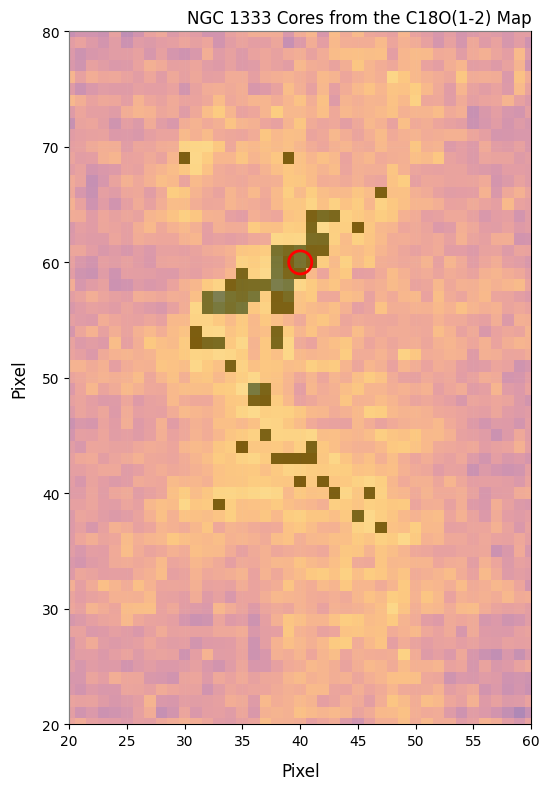

In [28]:
# THE FOLLOWING SHOWS THE IDENTIFIED CORES AND PLOT THE CIRCULAR APERTURE USED TO DERIVE ITS MASS (zoom view)

fig, ax = plt.subplots(figsize = (6, 9))
ax.grid(alpha = 0.05)
ax.set(xlim = (20, 60), ylim = (20, 80))
ax.set_xlabel('Pixel', fontsize = 12, labelpad = 10)
ax.set_ylabel('Pixel', fontsize = 12, labelpad = 10)
im = plt.imshow(moment0_18.value, origin = 'lower', cmap = 'inferno')
ax.imshow(core_mask, cmap = plt.cm.Greys, origin = 'lower', alpha = 0.5, zorder = 1000)
aperture.plot(color = 'red', lw = 2, zorder = 1000)
ax.set_title(f'NGC 1333 Cores from the C18O(1-2) Map', fontsize = 12, loc = 'right')

\newpage

*Is it stable against gravity or not?* 

We can determine if a core is stable or unstable against gravity (basically if it is forming stars or not) using the Jeans criterion and comparing to the actual mass of the core. In these cases, if ${\rm M}_{\rm core} > {\rm M}_{\rm Jeans}$ then the core is **unstable** and likely to collapse under gravity. Otherwise it is said that the core is stable and will resist gravitational collapse, i.e., not form stars. 

The Jeans mass is given by 

$$
{\rm M}_{\rm Jeans} = \frac{\pi^{5/2}}{6} \frac{c_s^3}{G^{3/2} \rho^{1/2}}
$$

where $c_s$ is the sound speed of the gas; related to its temperature via $c_s = \sqrt{\frac{k_B T}{\mu m_H}}$, $\rho$ is the gas density ($\rho = n_{\text{H}_2} \cdot \mu \cdot m_H$), $\mu$ is the mean molecular weight, which we assumed to be $2.3$, and $m_H = 1.67 \times 10^{-24} , \text{g}$ is the mass of a hydrogen atom

This expression can be also written as 

$$
{\rm M}_{\rm Jeans} = 2\left(\frac{c_s}{0.2~{\rm km/s}}\right)^3 \left(\frac{n}{10^3~{\rm cm}^{-3}}\right)^{-1/2}~[{\rm M}_\odot]
$$

In [29]:
mu = 2.3
m_H = m_p.cgs.value
G_cgs = G.cgs.value

T = tex_vals.mean()  # average excitation tempetature
c_s = np.sqrt((k_B.cgs.value * T) / (mu * m_H))  # in cm/s

L_cm = (0.1 * u.pc).to(u.cm).value # depth
n_H2 = N_H2 / L_cm  # number density [cm^-3]

In [30]:
cs_kms = (c_s*u.cm/u.s).to(u.km/u.s).value

MJ = 2 * (cs_kms / 0.2)**3 * (n_H2 / 1e3)**(1/2)
MJ * u.Msun

<Quantity 61.13416141 solMass>

In [31]:
# Is it stable?
if mass_Msun.value < MJ:
    print("The core is stable.")
else:
    print("The core is unstable.")

The core is stable.
